In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("sentiment-analysis-jumia-reviews.ipynb")

## Week 8 - Sentiment Analysis of Jumia Reviews

Product reviews are evaluations or opinions shared by consumers who have purchased and used a specific product or service. These reviews are typically written on online platforms such as e-commerce websites, social media, or review websites.

In this assignment, you will apply your knowledge of sentiment analysis to analyze the sentiments expressed in product reviews by Jumia customers. You will work together as a group to preprocess the text data, build a sentiment analysis model, and interpret the results.




In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

%matplotlib inline
import otter
grader = otter.Notebook()

In [3]:
pd.set_option('display.max_colwidth', None)

**Question 1:** Load the product reviews dataset into a variable called `customer_review_df`. Next, write a function called `check_data` to check if the data has been loaded successfully.

**Question 1.1:** Explore the distribution of sentiment labels in the dataset.

**Question 1.2** Engineer a new feature called `Sentiment` from the _Rating_ column. This takes the values -1, 0, and 1 for `negative`, `neutral`, and `positive`.
- Reviews with Rating > 3 is positive
- Reviews with Rating = 3 is neutral
- Reviews with Rating < 3 is negative

In [4]:
# load the customer retention dataset
customer_review_df = pd.read_csv(r"C:\Users\mercy\IDS\week-8-sentiment-analysis-mersaii\sentiment-analysis-jumia-reviews.csv")

# write a function called `check_data` to check data loading is successful
def check_data(data):
    if not data.empty:
        return True
    else:
        return 'data loading unsuccessful'

print(check_data(customer_review_df))

# Define a function to convert ratings to sentiments
def convert_to_sentiment(rating):
    if rating < 3:
        rating = -1
    elif rating == 3:
        rating = 0
    elif rating > 3:
        rating = 1
    return rating

# Apply the function to create a 'Sentiment' column
customer_review_df['Sentiment'] = customer_review_df['Rating'].apply(convert_to_sentiment)

customer_review_df.head()

True


,Rating,Title,Review,Sentiment
0,3,I like it,"The neck need to be adjusted, it's too big",0
1,1,not happy with product,You people should improve in the item's you people show to your customers.\nThe quality am expecting is not what am see and is not good ????????????????,-1
2,5,good,Well ok,1
3,4,Good,Was Fine,1
4,4,quality,Quality is very ok with size,1


**Question 2:** Preprocess the text data by completing the following:
- Convert the reviews to lowercase and remove punctuation. 
- Tokenize the text data to split it into individual words or tokens.

**Note**: Assign your final preprocessed dataset to a variable called `processed_customer_review_df`. Failure to do this might result in you not getting a score for this question.


To preprocess the data i used spacy to convert to lowercase(as sentement analyzers do not rely on the casing of words), remove punctuation and remove stop words to to enhance the quality and standardization of the text data. Additionally, i used lemmatization as this step contributes to the standardization of the text and aids in consolidating similar words, thereby enhancing the accuracy of sentiment analysis.

I engineered a 'Processed_Review' feature by applying the preprocessing function to the 'Review' column. As i wanted to keep my review column unmuted to allow future refrencing.

I tokenized the text data using nltk

In [5]:
nlp = spacy.load("en_core_web_sm")

# Preprocess text data
def preprocess_text(text):
    doc = nlp(text)
    # Using spacy, convert to lowercase, remove punctuation, and remove stop words
    text = ' '.join([token.lower_ for token in doc if not token.is_punct])
    # added lemmatization as a fine tuning step for text data stadardization
    text = ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop])
    return text

# Apply text preprocessing to 'Review' column
customer_review_df['Processed_Review'] = customer_review_df['Review'].apply(preprocess_text)

# Tokenize the text data using nltk
customer_review_df['Tokens'] = customer_review_df['Processed_Review'].apply(word_tokenize)

# Combine tokens into a string (needed for feature extraction)
customer_review_df['Tokens'] = customer_review_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

processed_customer_review_df = customer_review_df.copy()
processed_customer_review_df.head()

,Rating,Title,Review,Sentiment,Processed_Review,Tokens
0,3,I like it,"The neck need to be adjusted, it's too big",0,neck need adjust big,neck need adjust big
1,1,not happy with product,You people should improve in the item's you people show to your customers.\nThe quality am expecting is not what am see and is not good ????????????????,-1,people improve item people customer \n quality expect good,people improve item people customer quality expect good
2,5,good,Well ok,1,ok,ok
3,4,Good,Was Fine,1,fine,fine
4,4,quality,Quality is very ok with size,1,quality ok size,quality ok size


**Question 3:** Split your processed dataset into training and testing set by using `80:20` rule. You can use **X_train, X_test, y_train, y_test** variable to store your splitted dataset.

**Question 3.1:** Choose a feature extraction technique and implement it. You can choose from techniques like `BoW`, `TF-IDF`, or Word Embeddings. Remember to explain your choice.

**Question 3.2:** Train the sentiment analysis model using `MultinomialNB()` to analyse the reviews. 

**Note**: Assign your model to a variable called `sentiment_review_model`. Failure to do this might result in you not getting a score for this question.

For sentiment analysis tasks where the primary focus is on word frequency and simple models, i decided to use Bag of Words(Bow) feature extraction technique as it was simple and easy to implement for my fairly small data set, also it is good for tasks where frequency of words is important. Also, although a con of BoW ignores word order and semantics and may not capture the meaning or context well this didnt matter as for this sentiment analyzer, that worked fine.

MultinomialNB model was used because it's a suitable choice for sentiment analysis when we represent text using the Bag of Words approach, where we're interested in the distribution of words across positive, negative, and neutral sentiments as it learns from words in the reviews and uses that knowledge to predict the sentiment.

In [6]:

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(processed_customer_review_df['Tokens'], 
                                                        processed_customer_review_df['Sentiment'], test_size=0.2, random_state=42)

# Choose a feature extraction technique 
vectorizer = CountVectorizer(max_features=1000)  # Limit to the top 1000 words
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


# Create and train the sentiment analysis model
sentiment_review_model = MultinomialNB()
sentiment_review_model.fit(X_train_bow, y_train)


MultinomialNB()

**Question 4:** Predict using the developed model and evaluate the model. Evaluate this model using MAE, MSE, RMSE, and R-squared.

**Note**: Assign your prediction to a variable called `prediction`. Failure to do this might result in you not getting a score for this question.

Here, we calculate the different metrics to evaluate how well the model performed.
Accuracy: How often the model correctly predicted the sentiment.
Precision: How many of the predicted positive reviews were actually positive (and similarly for negative and neutral).
Recall: Of all the actual positive reviews, how many did the model correctly predict (and similarly for negative and neutral).
F1 Score: A balance between precision and recall, providing a single metric to assess overall performance.

These metrics collectively offer a comprehensive view of the model's effectiveness in sentiment analysis.

I used classification metrics to evaluate the performance of the model because sentiment analysis is fundamentally a classification problem. The goal is to predict the sentiment label (positive, negative, or neutral) for each text data. Classification metrics provide a quantitative measure of how well the model is performing in terms of its ability to correctly classify instances into their respective sentiment categories.

In [7]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# analyse reviews using the model
prediction = sentiment_review_model.predict(X_test_bow)

# evaluate the model using different metrics
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction, average='weighted')
recall = recall_score(y_test, prediction, average='weighted')
f1 = f1_score(y_test, prediction, average='weighted')

# Display the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.85
Precision: 0.80625
Recall: 0.85
F1 Score: 0.8274193548387097


c:\Users\mercy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

we perform cross-validation using the cross_validate function with a StratifiedKFold method. Stratified K-Fold ensures that each fold has the same distribution of sentiment classes as the entire dataset, which is crucial when dealing with imbalanced classes. In summary, this is essential for fine-tuning the model as using cross-validation allows us obtain a more reliable assessment of the models performance.

In [9]:
# Fine-tune the model using K-Fold Cross-Validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Use StratifiedKFold for better handling of imbalanced classes
# cv_results = cross_val_score(sentiment_review_model, X_train_bow, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
cv_results = cross_validate(sentiment_review_model, X_train_bow, y_train, cv=StratifiedKFold(n_splits=5), scoring=scoring)

# Print average cross-validation results
print("Average Accuracy:", cv_results['test_accuracy'].mean())
print("Average Precision:", cv_results['test_precision'].mean())
print("Average Recall:", cv_results['test_recall'].mean())
print("Average F1 Score:", cv_results['test_f1'].mean())

Average Accuracy: 0.8
Average Precision: 0.7742742673992673
Average Recall: 0.8
Average F1 Score: 0.7741452991452992


c:\Users\mercy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\mercy\AppData\Local\Temp\ipykernel_1268\1494700529.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette= sns.color_palette("pastel"))
C:\Users\mercy\AppData\Local\Temp\ipykernel_1268\1494700529.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette= sns.color_palette("pastel"))


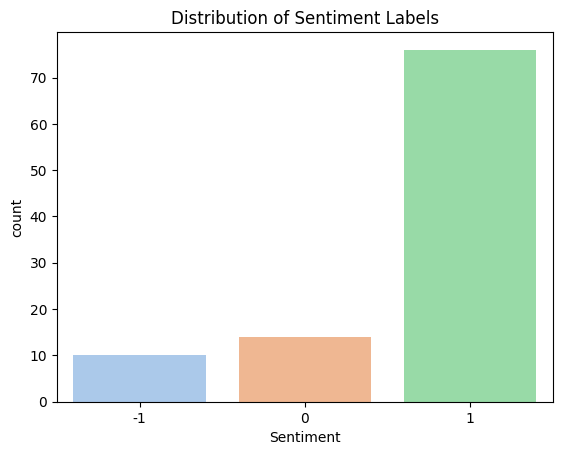

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of sentiment labels
sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette= sns.color_palette("pastel"))
plt.title('Distribution of Sentiment Labels')
plt.show()

C:\Users\mercy\AppData\Local\Temp\ipykernel_1268\1709130257.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette=sns.color_palette("pastel"))
C:\Users\mercy\AppData\Local\Temp\ipykernel_1268\1709130257.py:9: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette=sns.color_palette("pastel"))


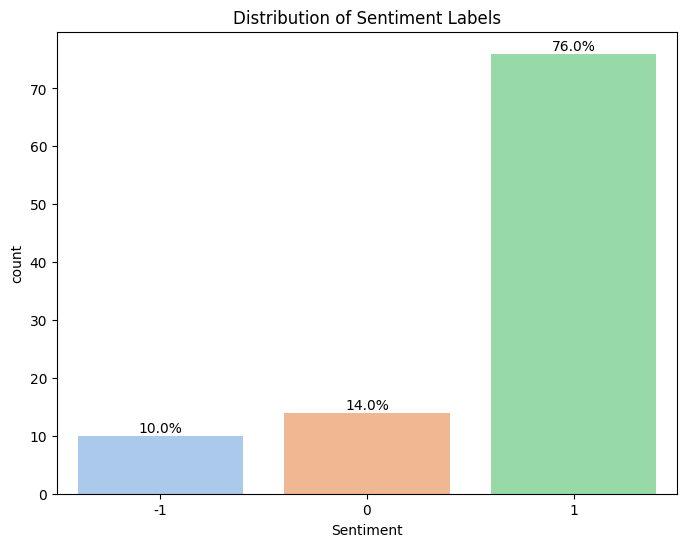

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of each sentiment category
sentiment_counts = processed_customer_review_df['Sentiment'].value_counts(normalize=True) * 100

# Visualize the distribution of sentiment labels with percentage plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=processed_customer_review_df['Sentiment'], data=processed_customer_review_df, palette=sns.color_palette("pastel"))

# Annotate bars with percentage values
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Distribution of Sentiment Labels')
plt.show()

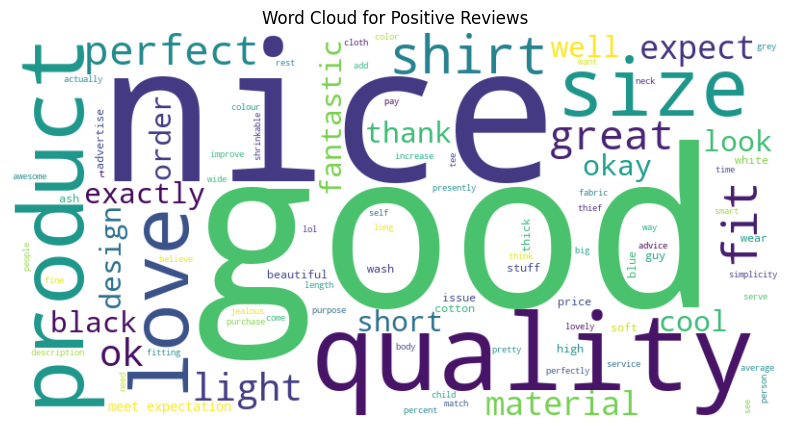

In [12]:
from wordcloud import WordCloud

# WordCloud for positive reviews
positive_reviews = processed_customer_review_df[processed_customer_review_df['Sentiment'] == 1]['Processed_Review'].str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# WordCloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

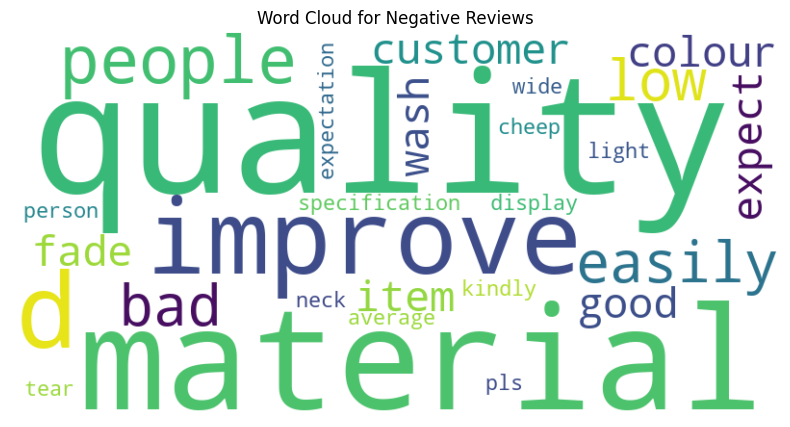

In [13]:

# WordCloud for negative reviews
negative_reviews = processed_customer_review_df[processed_customer_review_df['Sentiment'] == -1]['Processed_Review'].str.cat(sep=' ')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot WordCloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

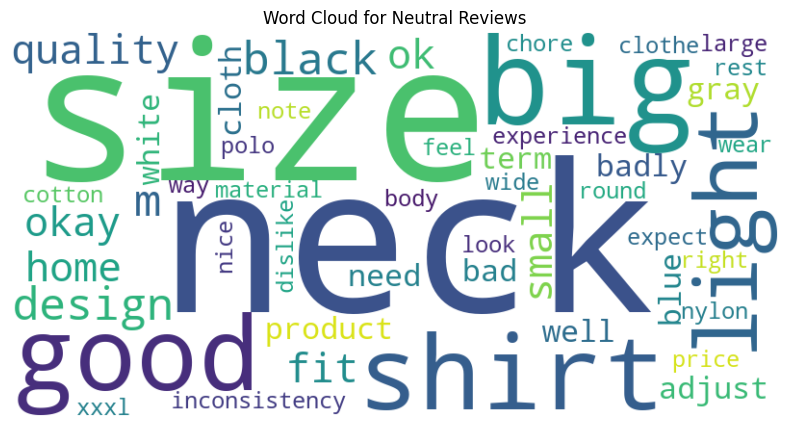

In [14]:
# WordCloud for neutral reviews
neutral_reviews = processed_customer_review_df[processed_customer_review_df['Sentiment'] == 0]['Processed_Review'].str.cat(sep=' ')
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_reviews)

# Plot WordCloud for neutral reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

<!-- BEGIN QUESTION -->

**Question 5:** What insight can you derive from this data?

The data shows a high number of positive sentiments(76%) which can imply that most customers are okay with the current state of the product. Looking further into the word cloud for the neutral sentiments, some seem to be fairly satisfied as they believe the price is fair for the quality. Some common words between the negative(10%) and neutral(14%) groups point to the material in terms of colour washing and fading. Another common term seems to be the neck size of the product and an overall inconsistency in product size and product colour delivered to the customers. Another insight gained is that the quality of product expected in terms of material was not delivered ths could imply that the product description during sale was not detailed enough.

In [16]:
import joblib

# save the model to a .pkl file
joblib.dump(sentiment_review_model, 'sentiment_model.pkl')

In [17]:
# save the vectorizer to a .pkl file
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

<!-- END QUESTION -->

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

These are some submission instructions.

In [15]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

PandocMissing: Pandoc wasn't found.
Please check that pandoc is installed:
https://pandoc.org/installing.html